# First data exploration
in this file I'm going to explore the data. By doing:
- Define your labels/response in a categorical manner (high response, low response, late response,..) based on the behaviour of the antibody titers of these individuals. This is what is usually done, or you can keep the antibodies as numbers and try and predict the numerical value.
- Not do much feature engineering and focus to first see what a couple of methodologies can predict as a starter
- Group the features based on coexpression/do a first dimensionality reduction (PCA) and group features based on the biplot of the PCA.
- You can look up what some of these features mean and maybe use your findings to guide your way of combining them but I would keep a data driven approach
- Since you still have more than one dataset you could look at different ways of combining the information, either at the start or by building separate models for each dataset
- You will have to keep in mind that:
  - you have to somehow encode multiple features into a single feature
  - deal with low number of samples also in the way you evaluate the models
  - define the feature contributions at all steps as explainability is a big component of this kind of work
  - There may be missing values to deal with

### loading all datasets

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm  # Import tqdm for the loading bar
from scipy.stats import f_oneway, chi2_contingency
from helper_functions.helper import model_with_shap

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [65]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/abtiters.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')

# Load the cyto data
cyto = pd.read_csv('../data/cyto_data.csv')

In [66]:
# Display the first few rows of each dataset
print("Abutters (antibody titers) dataset:")
print(abtiters.head())

print("\nCytokines dataset:")
print(cytokines.head())

print("\nCyto dataset:")
print(cyto.head())

Abutters (antibody titers) dataset:
        vaccine Vaccinee  Day 0  Day 21
0  Anti-Measles       M1    5.0   226.0
1  Anti-Measles      M11   10.9    24.2
2  Anti-Measles      M12  300.0   300.0
3  Anti-Measles      M13  176.0   300.0
4  Anti-Measles      M14   16.4   300.0

Cytokines dataset:
  Vaccinee  CMV.Status  EBV.Status  HSV1_2.Status  HHV6.Status     EGF  \
0       M1           1           1              0            0  278.88   
1       M2           1           1              0            0  238.38   
2       M3           0           1              0            1   96.75   
3       M4           0           0              0            1  376.30   
4       M5           0           1              0            1  245.51   

    FGF-2  Eotaxin  TGF-a   GCSF  ...   IL-6   IL-7   IL-8   IP-10   MCP-1  \
0  497.14   189.07  26.77  20.26  ...  19.40  14.77  57.72  111.55  379.73   
1   33.20   206.11   2.09   2.36  ...   1.99   2.47  18.02  113.51  539.30   
2  166.84    96.33   2.09

###### Antibody Titers Dataset:
| Column Name | Description |
| --- | --- | 
| vaccine | The type of vaccine administered to the individual (e.g., Anti-Measles). |
| Vaccinee | The identifier for the individual receiving the vaccine (e.g., M1, M11). |
| Day 0 | The measured antibody titer on Day 0, which is typically the baseline measurement before vaccination. |
| Day 21 | The measured antibody titer on Day 21, indicating the antibody response after vaccination. (could be an important signal for how well the individual responded to the vaccine.) |


###### Cytokines Dataset:
| Column Name | Description |
| --- | --- | 
| Vaccinee | Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset). |
| CMV.Status | Cytomegalovirus infection status (binary: 1 = positive, 0 = negative). |
| EBV.Status | Epstein-Barr Virus infection status (binary: 1 = positive, 0 = negative). |
| HSV1_2.Status	| Herpes Simplex Virus (types 1 and 2) infection status (binary). |
| HHV6.Status | Human Herpesvirus 6 infection status (binary). |
| EGF | Measured concentration of Epidermal Growth Factor (EGF) in the blood. |
| FGF-2	| Fibroblast Growth Factor-2 concentration. |
| Eotaxin | A cytokine responsible for eosinophil recruitment. |
| TGF-a | Transforming Growth Factor-alpha concentration. |
| GCSF | Granulocyte Colony-Stimulating Factor concentration, which promotes the growth of white blood cells. |
| ... | .	Other columns represent various cytokines and their concentrations, including inflammatory and immune response markers like IL-6, TNFa, VEGF, etc. |

###### Cyto Dataset:
| Column Name | Description |
|-------------| --- | 
| Vaccinee    |	Identifier for the individual (should match with the Vaccinee field in the Antibody Titers dataset).|
| WBC         |	White Blood Cells count, important for the immune system's ability to fight infections.|
| RBC	        | Red Blood Cells count, responsible for carrying oxygen throughout the body.|
| HGB	        | Hemoglobin level, the protein in RBCs that carries oxygen to tissues.|
| HCT	        | Hematocrit, the percentage of blood composed of red blood cells.|
| PLT	        | Platelets count, crucial for blood clotting and preventing excessive bleeding.|
| %LYM        |	Percentage of lymphocytes in total WBC, important in the adaptive immune response.|
| %MON        |	Percentage of monocytes in total WBC, involved in removing dead cells and fighting certain infections.|
| %GRA        |	Percentage of granulocytes in total WBC, essential for fighting bacterial infections and inflammation.|

In [67]:
# Check for missing values and data types
print("\nAbutters missing values and data types:")
print(abtiters.info())

print("\nCytokines missing values and data types:")
print(cytokines.info())

print("\nCyto missing values and data types:")
print(cyto.info()) # there are some missing values

# Drop non-numeric columns
cyto_non_numeric = cyto[['Vaccinee']]
cyto_numeric = cyto.select_dtypes(include=[float, int])

# Use the 5 nearest neighbors to fill in the missing values
imputer = KNNImputer(n_neighbors=5)
cyto_filled = imputer.fit_transform(cyto_numeric)

# Convert the result back into a DataFrame with the original column names
cyto_filled_df = pd.DataFrame(cyto_filled, columns=cyto_numeric.columns)
cyto_final = pd.concat([cyto_non_numeric.reset_index(drop=True), cyto_filled_df], axis=1)


Abutters missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   vaccine   40 non-null     object 
 1   Vaccinee  40 non-null     object 
 2   Day 0     40 non-null     float64
 3   Day 21    40 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.4+ KB
None

Cytokines missing values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Vaccinee       40 non-null     object 
 1   CMV.Status     40 non-null     int64  
 2   EBV.Status     40 non-null     int64  
 3   HSV1_2.Status  40 non-null     int64  
 4   HHV6.Status    40 non-null     int64  
 5   EGF            40 non-null     float64
 6   FGF-2          40 non-null     float64
 7   Eotaxin        40 no

### playing around with the data

##### 1 - Decide on target labels


Abutters dataset with titer response:
  Vaccinee  Day 0  Day 21  titer_response
0       M1    5.0   226.0           221.0
1      M11   10.9    24.2            13.3
2      M12  300.0   300.0             0.0
3      M13  176.0   300.0           124.0
4      M14   16.4   300.0           283.6


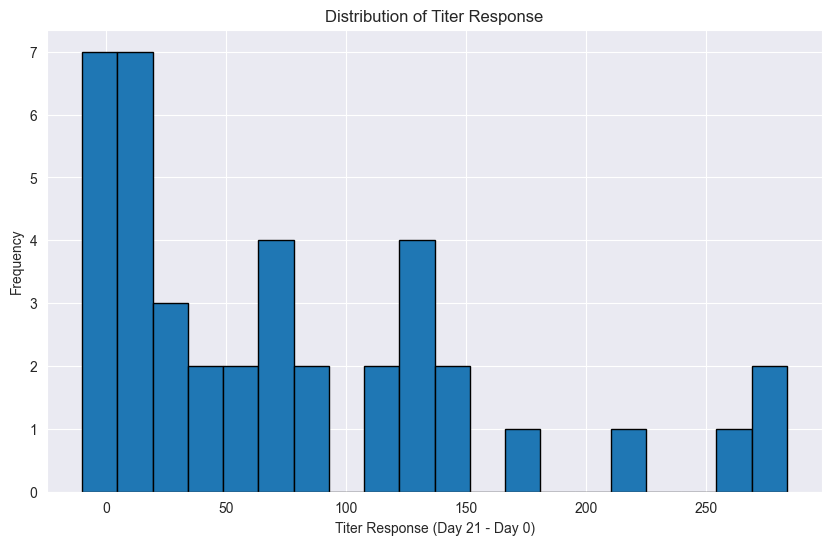


Abutters dataset with response labels:
  Vaccinee  titer_response response_label
0       M1           221.0           high
1      M11            13.3            low
2      M12             0.0            low
3      M13           124.0           high
4      M14           283.6           high

Frequency of responses:
response_label
low     27
high    13
Name: count, dtype: int64


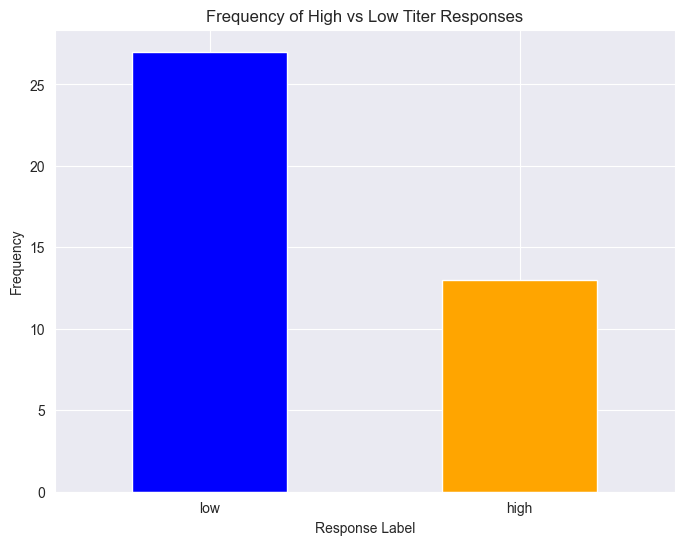

In [68]:
# Calculate the difference between Day 21 and Day 0 antibody titers
abtiters['titer_response'] = abtiters['Day 21'] - abtiters['Day 0']

print("\nAbutters dataset with titer response:")
print(abtiters[['Vaccinee', 'Day 0', 'Day 21', 'titer_response']].head())

# Plot the distribution of titer_response
plt.figure(figsize=(10, 6))
plt.hist(abtiters['titer_response'], bins=20, edgecolor='black')
plt.title('Distribution of Titer Response')
plt.xlabel('Titer Response (Day 21 - Day 0)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Define a threshold for high vs. low response
threshold = 100  # I chose 100 based on the plot (a little trail and error)
abtiters['response_label'] = abtiters['titer_response'].apply(lambda x: 'high' if x > threshold else 'low')

print("\nAbutters dataset with response labels:")
print(abtiters[['Vaccinee', 'titer_response', 'response_label']].head())

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

##### 2 - Numerical Prediction (small test but not saying much because I used a very simple model)
i am also looking to see if i can predict the response category based only on the Cytokine data

Mean Squared Error: 3.248095527094853
    Actual   Predicted
19   282.2  284.734045
16     9.6    9.872567
15    74.2   74.430180
26   133.2  131.640792
4    283.6  279.484494
Mean Squared Error: 3.248095527094853
Mean Absolute Error: 1.1388961523930883
R-squared: 0.9997056344666622


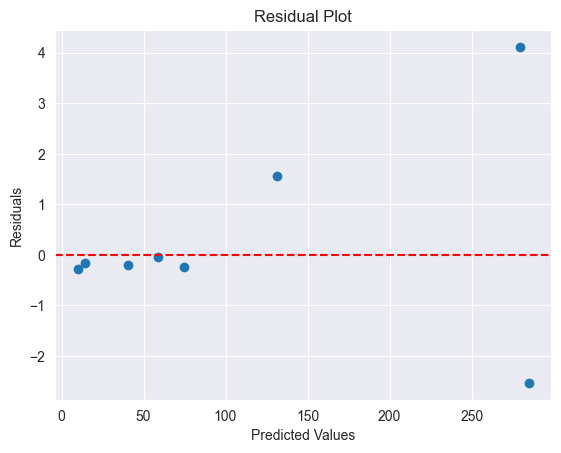

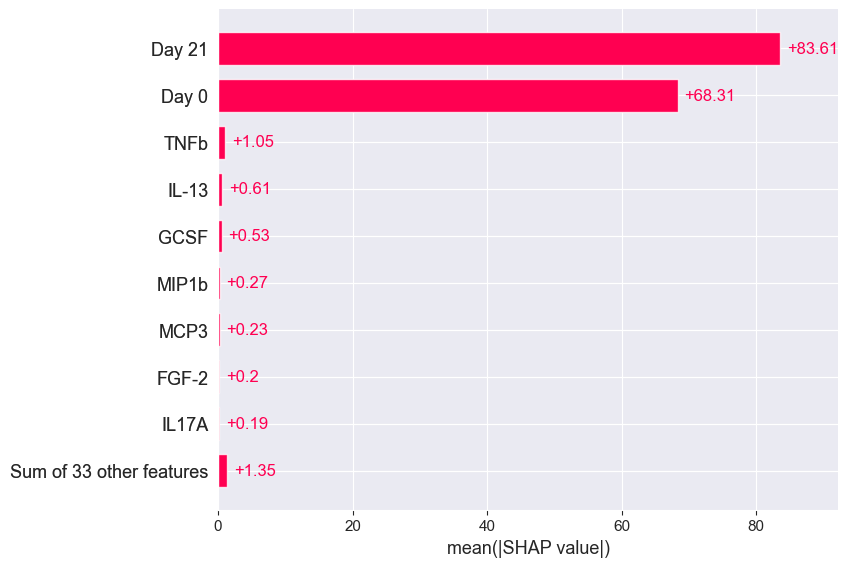

In [69]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data.drop(columns=['titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['titer_response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Residual analysis (using y_test - y_pred)
residuals = y_test - y_pred

# Scatter plot of predicted vs residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### SHAP Analysis ###
# SHAP values for the Linear Regression model
explainer = shap.Explainer(regressor, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Feature Importance)
shap.plots.bar(shap_values)

these results are pretty logical since i try to predict a metric "titer_response" that is calculated on Day 0 and Day 21. If i only train the model with these 2 parameters the model is near perfect because it just captures the calculation. let's see what removing Day 0 and Day 21 does. (we get even better results not including the rest of the data but only the Day 0 and Day 21 so the model just captures the math behind it)

Mean Squared Error: 3558866.072697993
    Actual    Predicted
19   282.2  3300.718108
16     9.6   135.357783
15    74.2   166.656322
26   133.2 -1060.459171
4    283.6 -3941.567353
Mean Squared Error: 3558866.072697993
Mean Absolute Error: 1129.289905559687
R-squared: -321.5297719321468


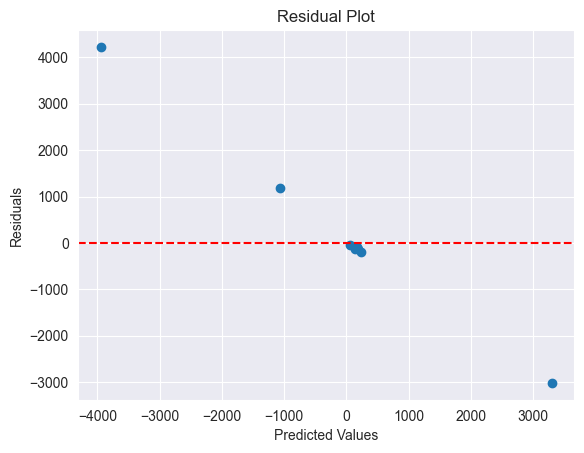

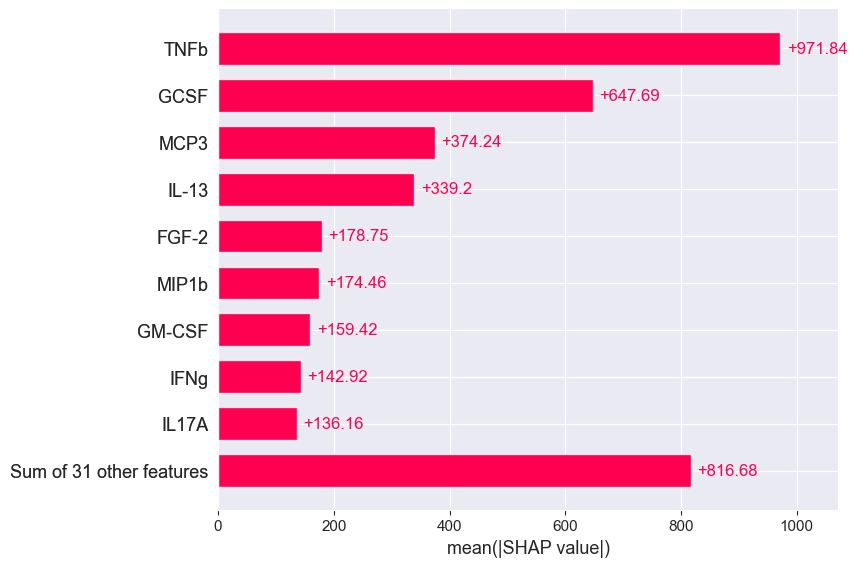

In [70]:
# Drop non-numeric columns
X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['titer_response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Residual analysis (using y_test - y_pred)
residuals = y_test - y_pred

# Scatter plot of predicted vs residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### SHAP Analysis ###
# SHAP values for the Linear Regression model
explainer = shap.Explainer(regressor, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Feature Importance)
shap.plots.bar(shap_values)


Okay the very badd results with a linear model suggests that a linear model may not be appropriate for this dataset, especially given the complexity of immune responses and cytokine interactions. The large errors for some predictions (like predicting 3300 instead of 282.2) suggest that the model is struggling to fit the data well, possibly due to outliers or high variability in the cytokine levels. I'm going to see what results i become when i have a non-linear model like a RandomForestClassifier. And i'm going to predict the category ('high' or 'low')

### To approach feature selection and get a clearer path, here's a structured framework you can follow:

1. Preliminary Data Analysis and Cleaning
Data Inspection: Examine data distribution, missing values, and outliers.
Feature Filtering: Remove features with high missingness or very low variance, as they may not be informative.

2. Initial Feature Importance Assessment
Univariate Feature Analysis: Use simple tests (e.g., ANOVA, t-tests) to see which cytokines or other features significantly differ across response groups. This can give early insights into potential markers.
Random Forest for Baseline Importance: Run Random Forest to get a quick overview of feature importances. You’ve already started this, which is a great choice due to Random Forest's robustness with high-dimensional data.

3. Iterative Feature Selection with SHAP
Refined SHAP Analysis: Focus on SHAP values to interpret the influence of top features identified in Random Forest.
Recursive Feature Elimination: Pair SHAP with recursive feature elimination (RFE) or similar methods, iteratively reducing the feature set based on importance.

4. Testing Alternative Models
Experiment with other models like XGBoost or logistic regression with L1 regularization (lasso) for additional perspectives on feature importance. XGBoost can also pair well with SHAP for interpretability and is particularly effective with high-dimensional data.

5. Cross-Vaccine Validation Preparation
If you have access to data from other vaccines, validate your model with these datasets to check for marker consistency across vaccine types. This step solidifies generalizability.
This process provides a structured way to approach feature importance analysis and potentially validates immune markers across different models and vaccines. Let me know if you'd like code examples or a more detailed look into any specific step.

#### 1 Preliminary Data Analysis and Cleaning

In [71]:
## abtiters already loaded ##
## cytokines already loaded ##
cyto = cyto[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']] # already loaded


metadata = pd.read_csv('../data/metadata.csv')

gender_mapping = {'M': 1, 'F': 0}
metadata['Gender'] = metadata['Gender'].map(gender_mapping)

In [72]:
# Combine all data into a single DataFrame for easy processing
cytokines_data = cytokines.drop(columns=['Vaccinee','CMV.Status','EBV.Status','HSV1_2.Status','HHV6.Status'])
cyto_data = cyto.drop(columns=['Vaccinee'])

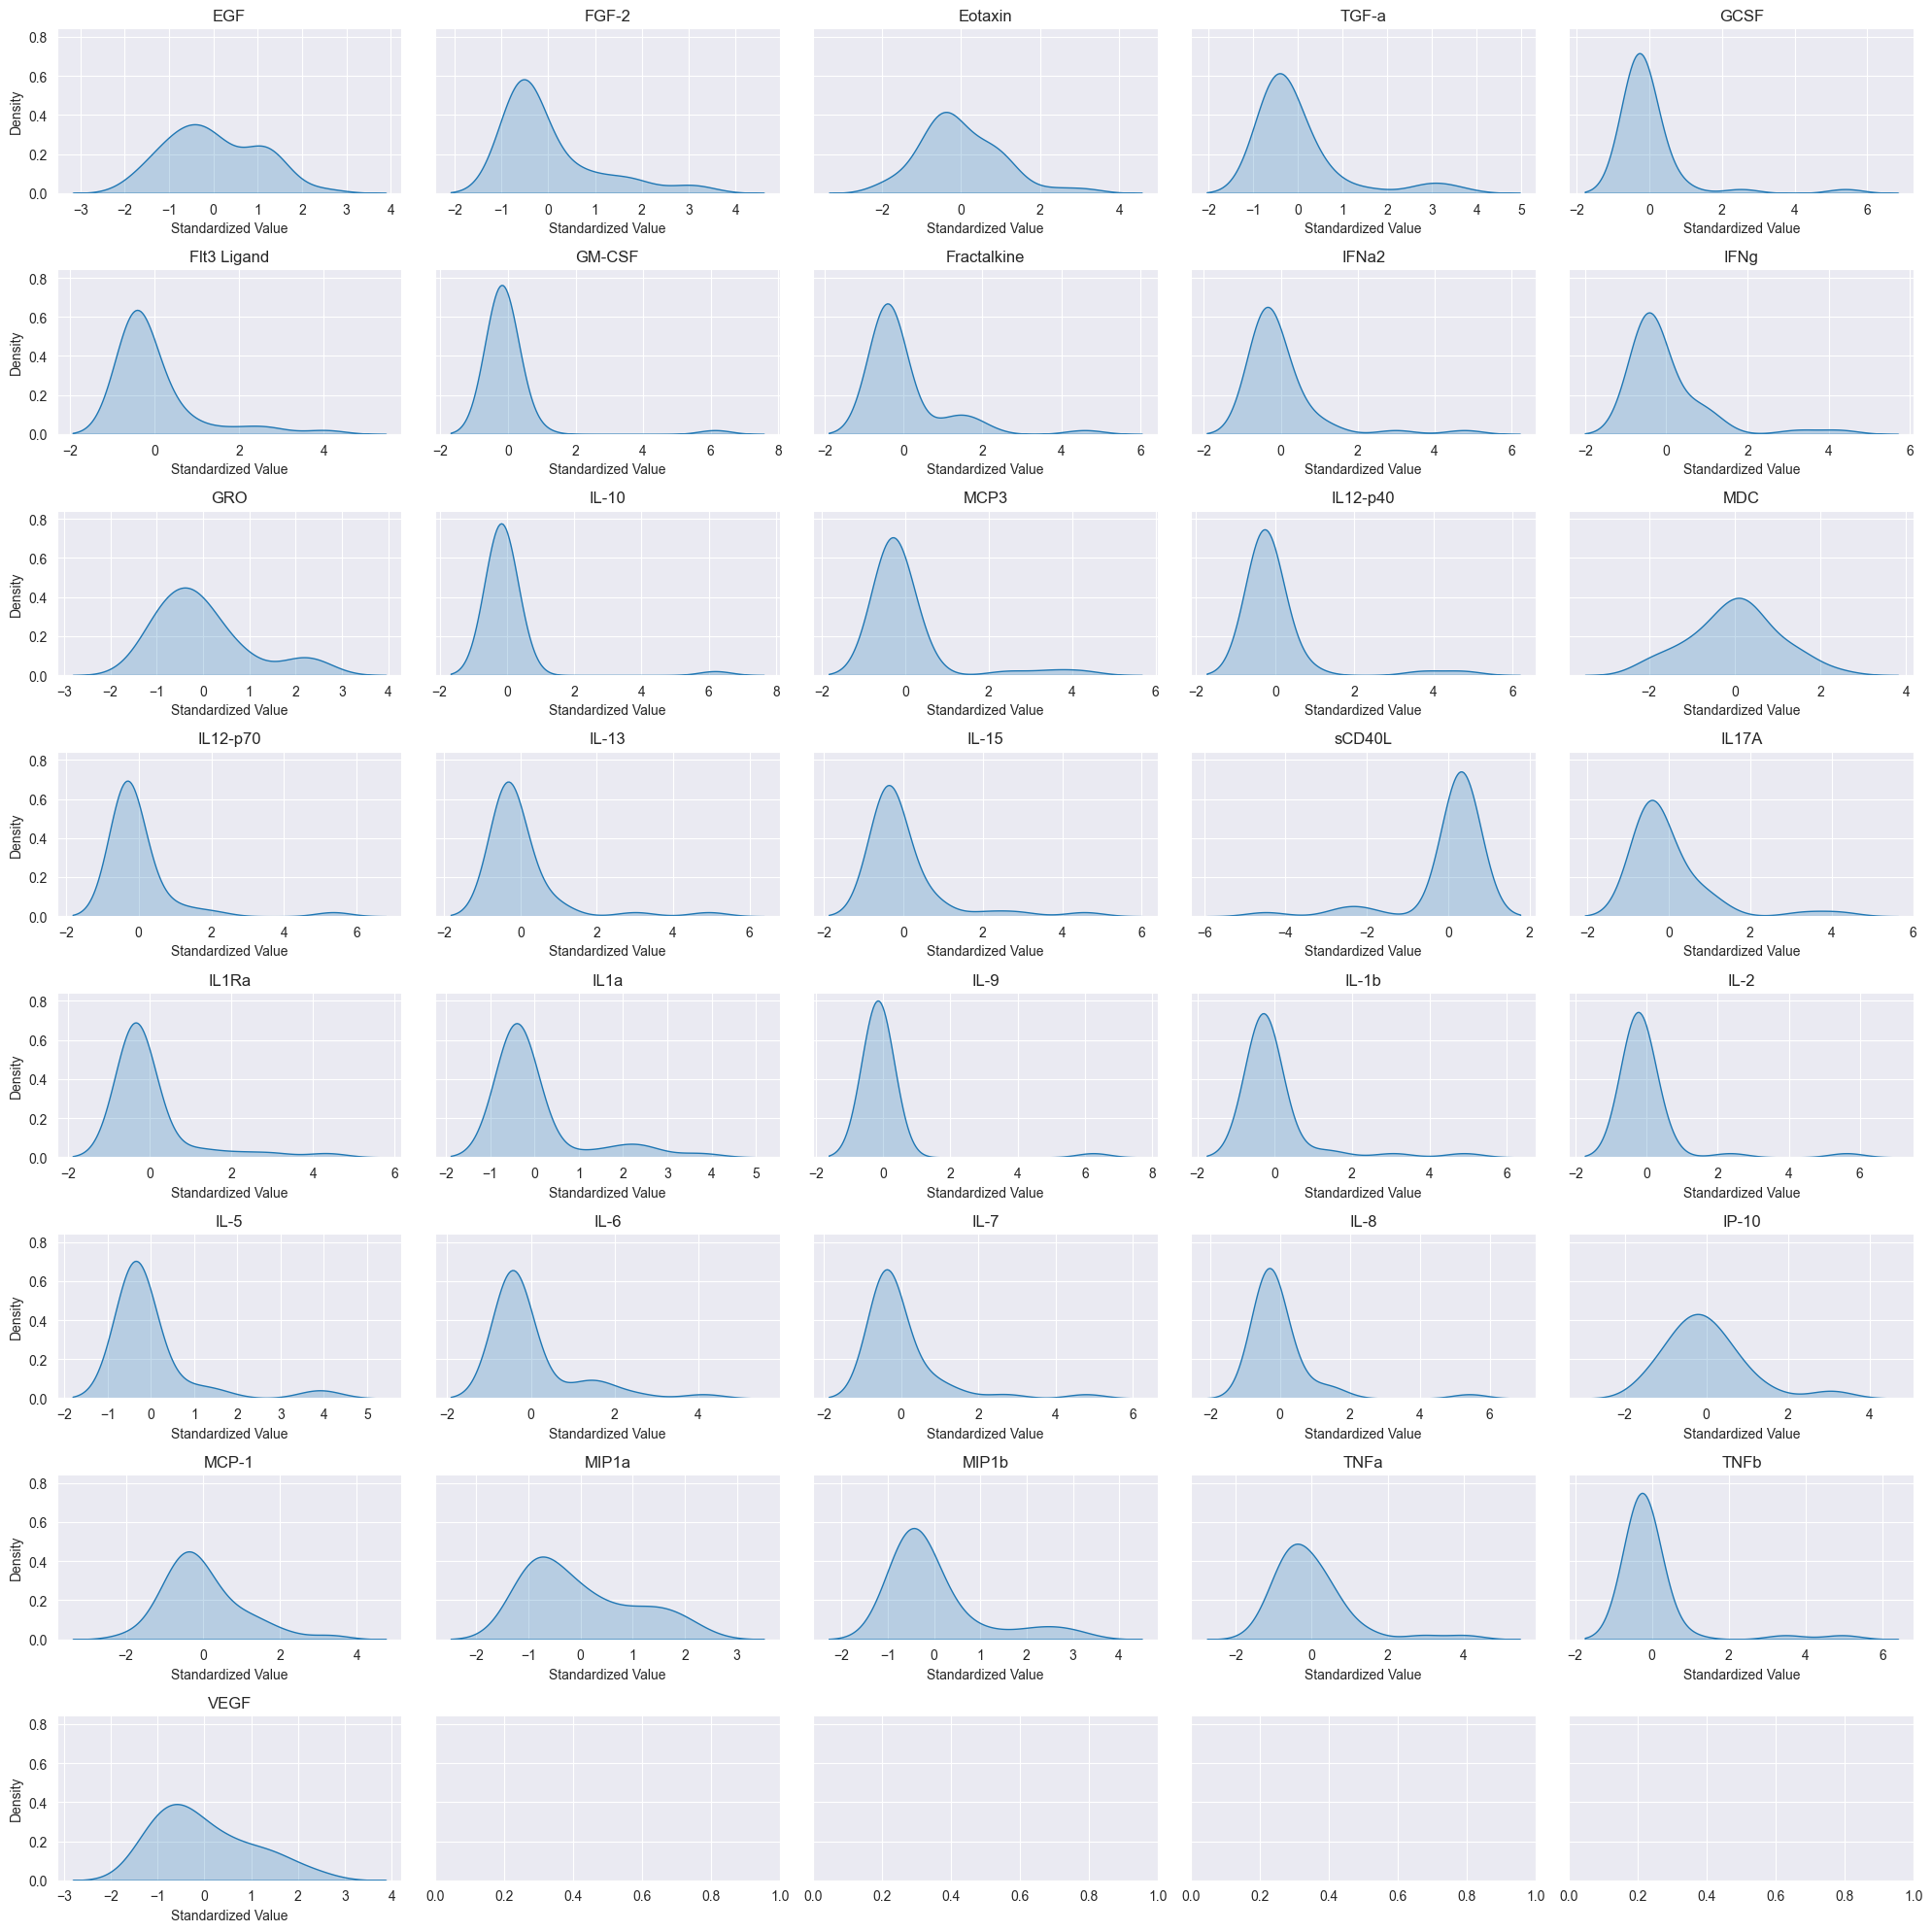

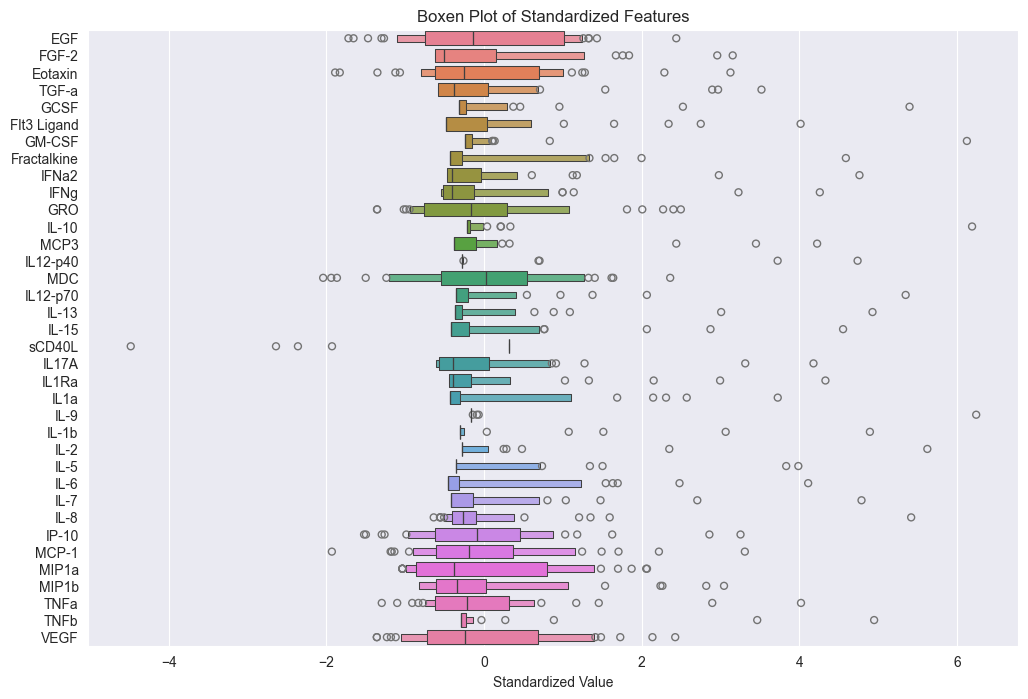

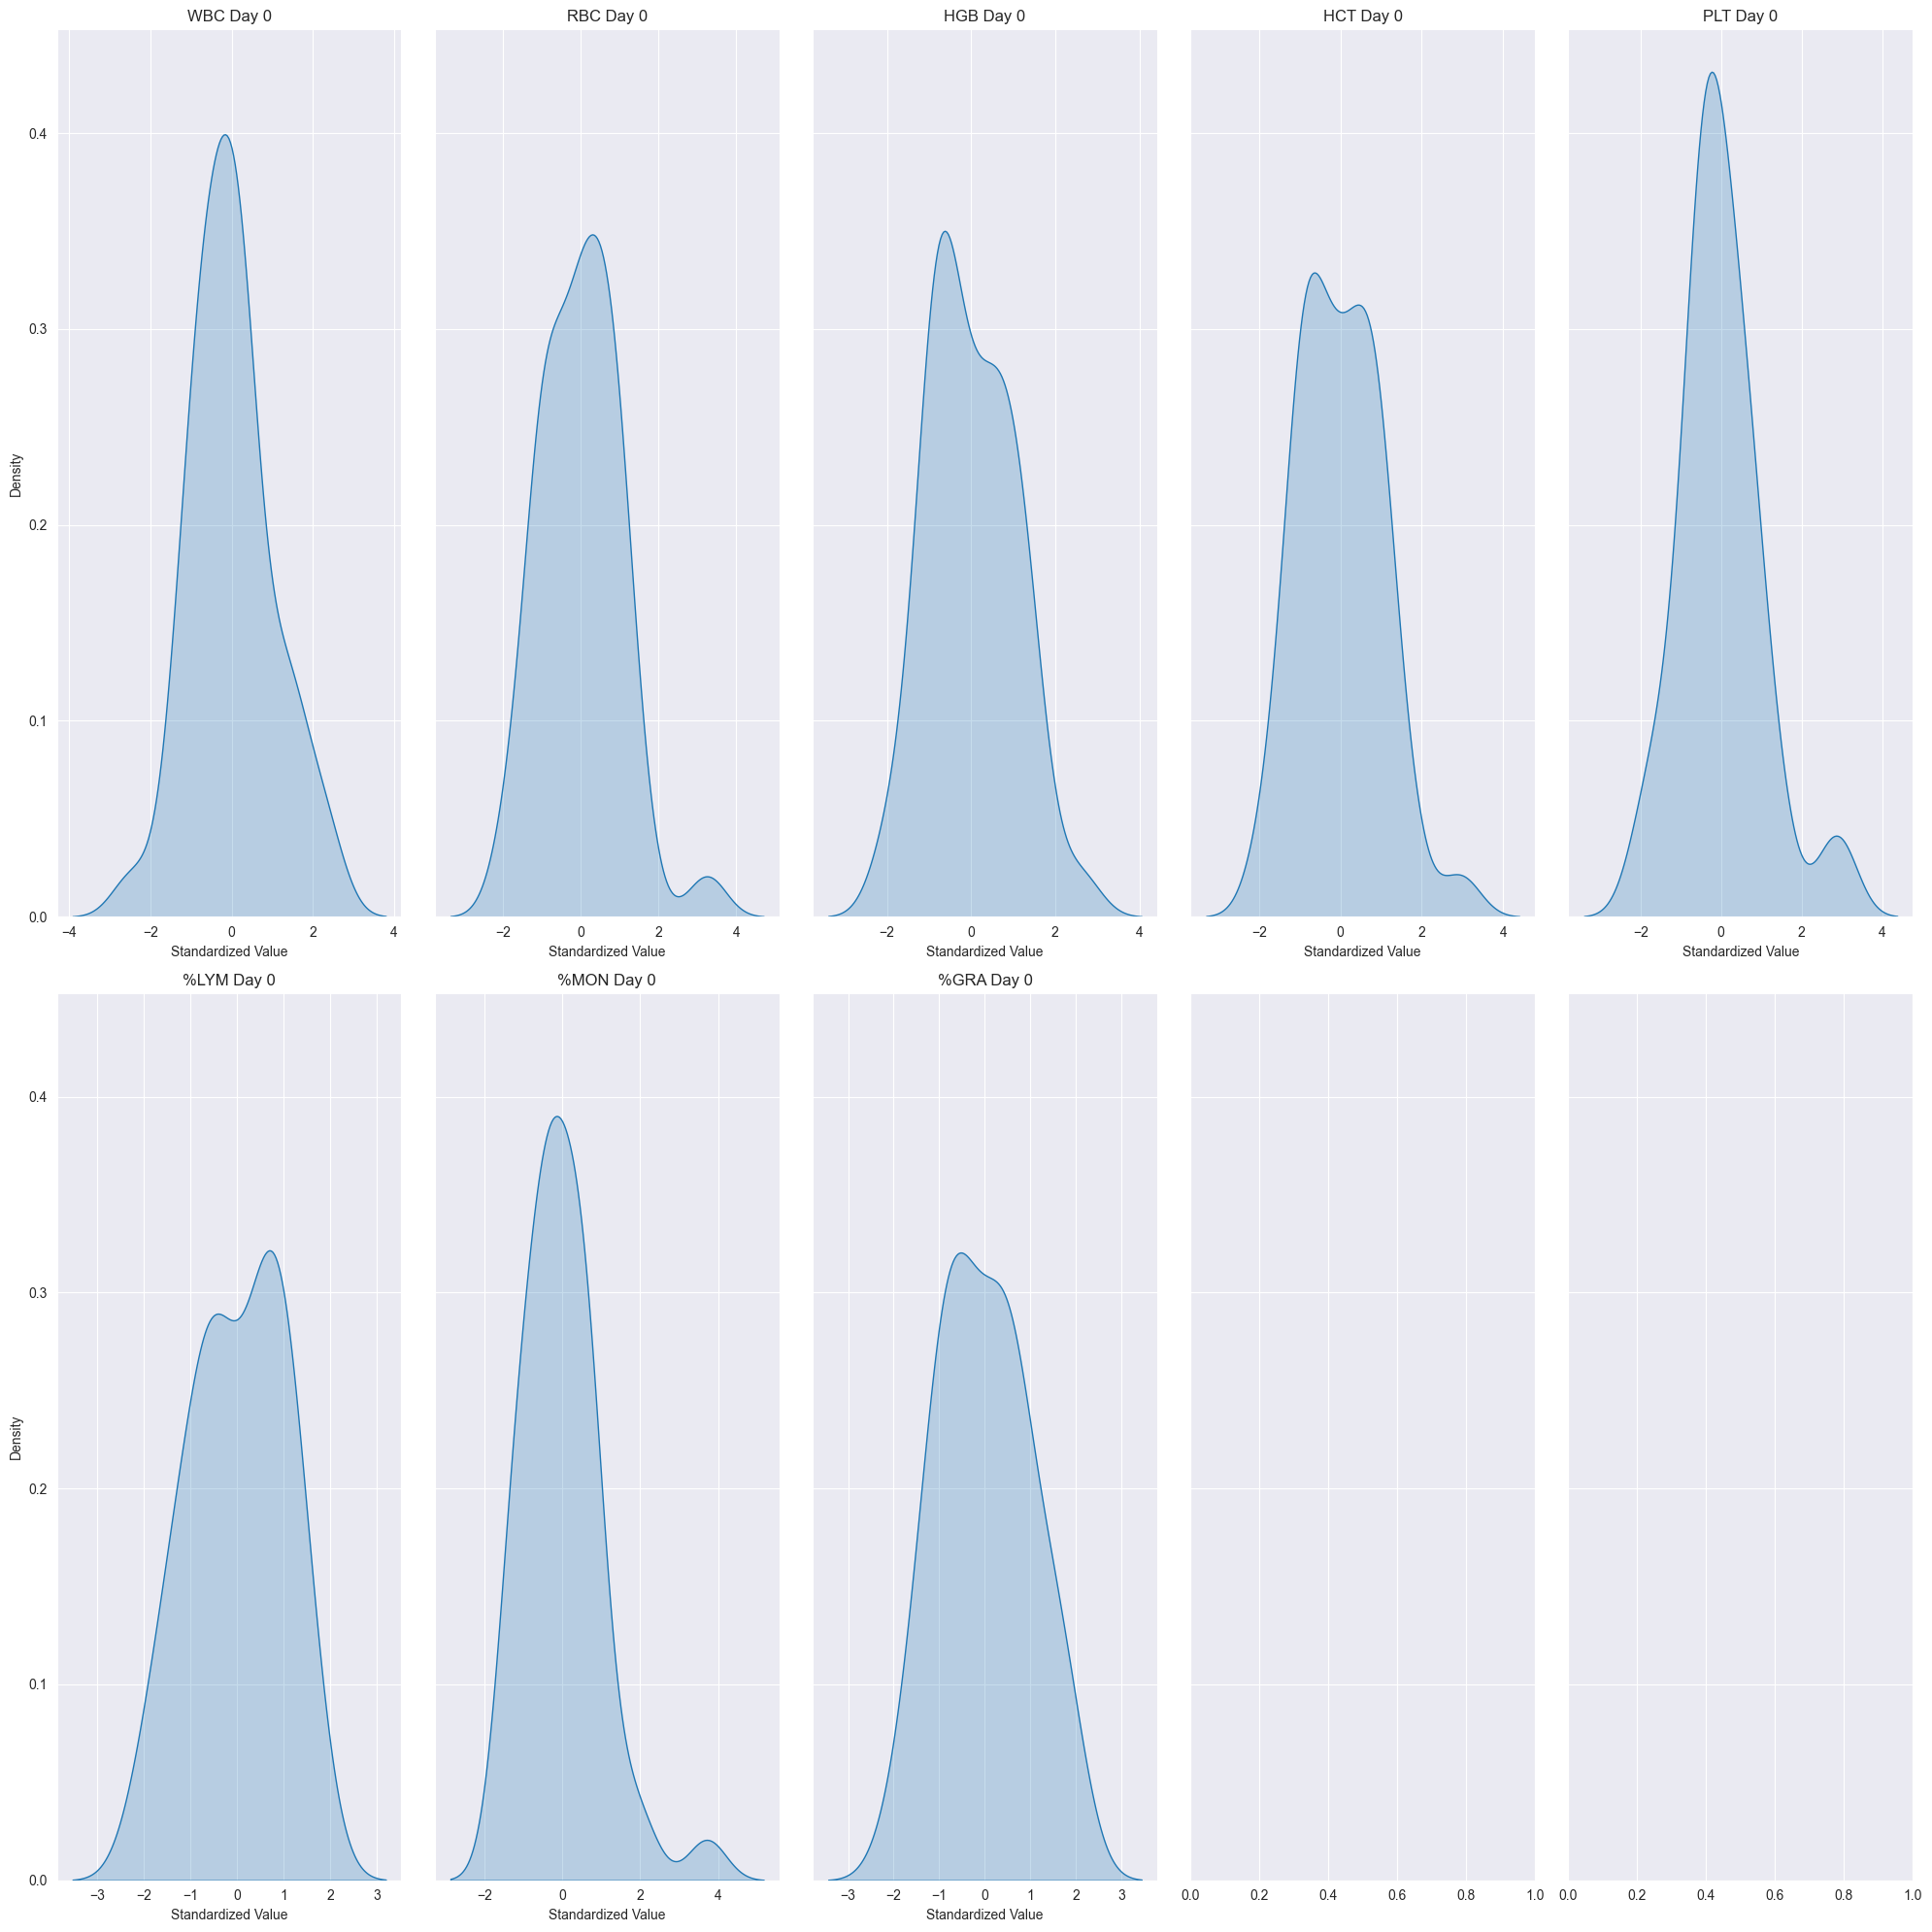

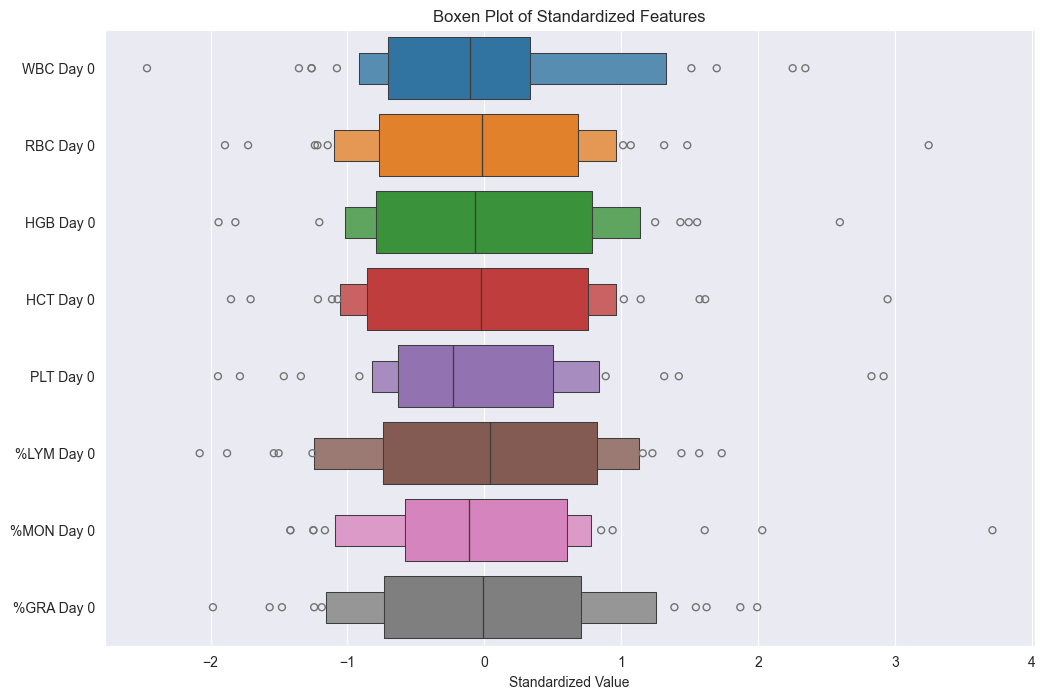

In [73]:


def preliminary_data_analysis(data):
    # Apply standard scaling (z-score normalization)
    scaler = StandardScaler()
    all_data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    num_columns = 5  # Number of columns in the grid
    num_rows = (len(all_data_normalized.columns) + num_columns - 1) // num_columns
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20), sharey=True)
    axes = axes.flatten()
    
    for i, column in enumerate(all_data_normalized.columns):
        sns.kdeplot(all_data_normalized[column], ax=axes[i], fill=True)
        axes[i].set_title(column)
        axes[i].set_xlabel("Standardized Value")
        axes[i].set_ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.boxenplot(data=all_data_normalized, orient='h')
    plt.title("Boxen Plot of Standardized Features")
    plt.xlabel("Standardized Value")
    plt.show()

preliminary_data_analysis(cytokines_data)
preliminary_data_analysis(cyto_data)

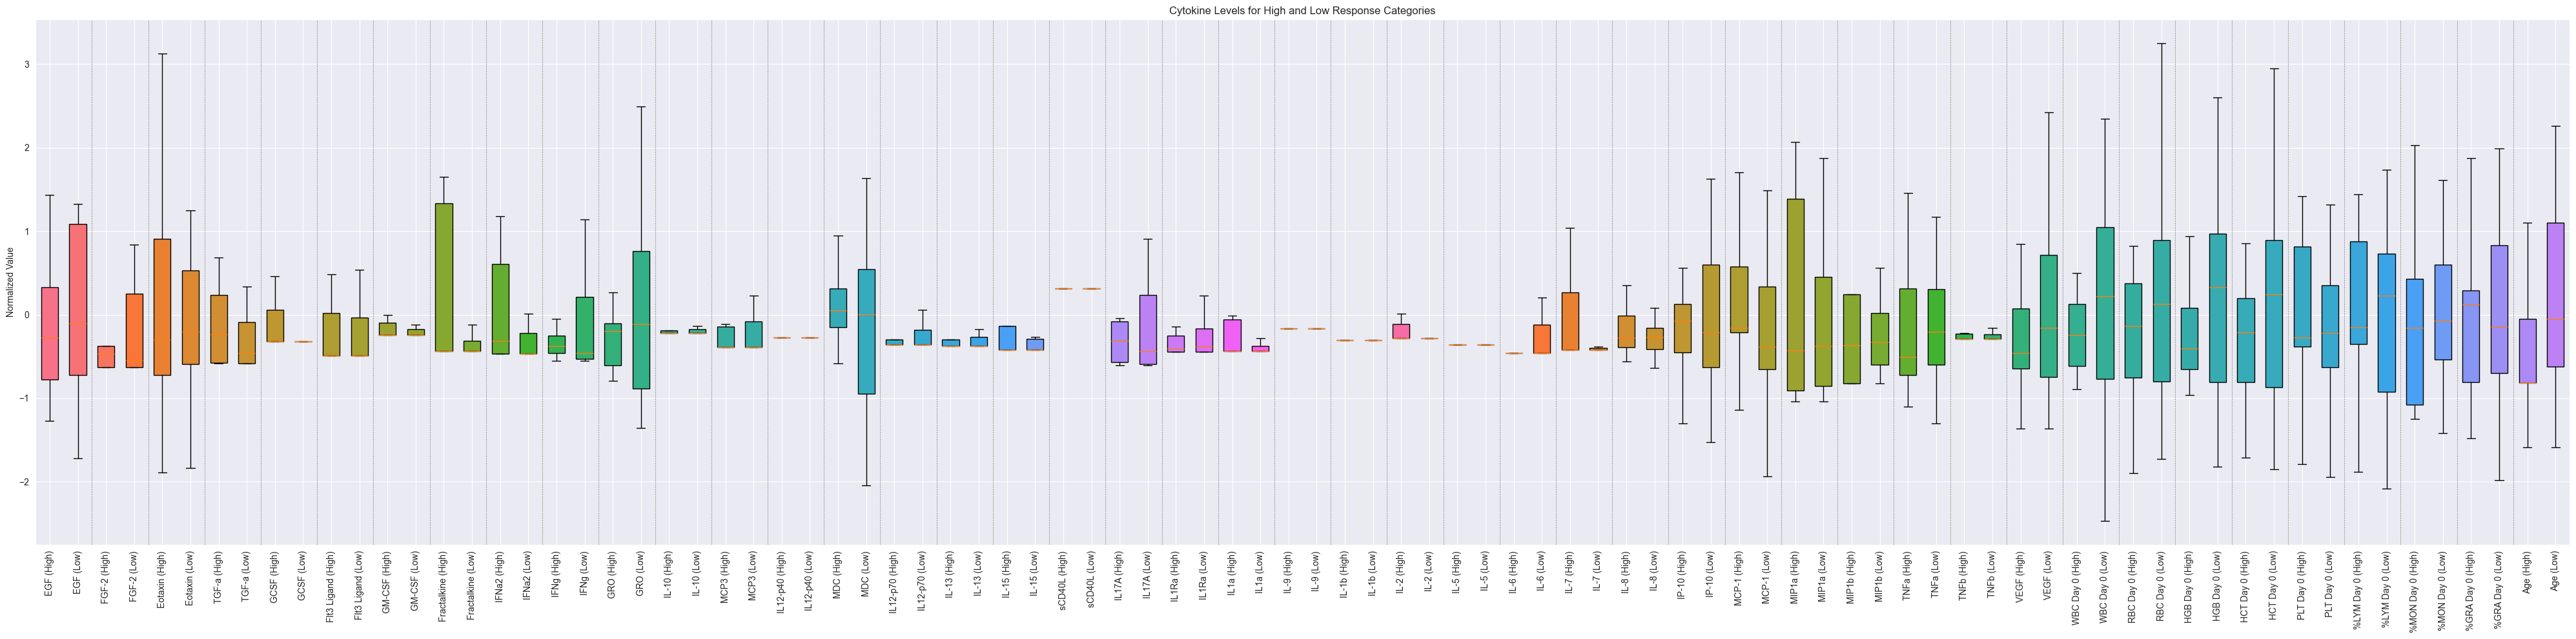

In [94]:
def distribution_of_the_data(data, labels, outliers=True):
    # Standardize the feature values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    X_scaled = pd.DataFrame(X_scaled, columns=data.columns)
    X_scaled['response_label'] = labels
    
    # Split the data into High and Low response categories
    high_response = X_scaled[X_scaled['response_label'] == 'high']
    low_response = X_scaled[X_scaled['response_label'] == 'low']
    
    # Prepare data for side-by-side boxplots
    data_to_plot = []
    labels = []
    binary_features = []
    non_binary_features = []
    
    for col in data.columns:
        # Check if the column is binary (i.e., has exactly two unique values, e.g., 0 and 1)
        if data[col].nunique() == 2:
            binary_features.append(col)
        else:
            # Add non-binary features to the box plot data
            data_to_plot.append(high_response[col])
            data_to_plot.append(low_response[col])
            labels.append(f"{col} (High)")
            labels.append(f"{col} (Low)")
            non_binary_features.append(col)
    
    # Set up color palette for alternating colors
    colors = sns.color_palette("husl", n_colors=len(data.columns))
    
    # Plot
    fig, ax = plt.subplots(figsize=(40, 10))
    box = ax.boxplot(data_to_plot, showfliers=outliers, widths=0.6, patch_artist=True)
    
    # Apply colors to each pair of boxes
    for i, (patch, color) in enumerate(zip(box['boxes'], colors * 2)):
        patch.set_facecolor(color)
    
    # Customizing data-axis
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title("Cytokine Levels for High and Low Response Categories")
    ax.set_ylabel("Normalized Value")
    
    # Adding vertical grid lines for separation
    for i in range(2, len(labels) + 1, 2):
        ax.axvline(i + 0.5, color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
cytokines_cyto = pd.merge(cytokines, cyto, on='Vaccinee')
merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
merged_data = pd.merge(abtiters, merged, on='Vaccinee')

# Assuming 'merged_data' is loaded and structured with response labels and features
# Separate features and response labels
X = merged_data.drop(columns=['Day 0', 'Day 21','titer_response', 'Vaccinee', 'response_label', 'vaccine'])
y = merged_data['response_label']

distribution_of_the_data(X, y, outliers=False)


##### Features with Potential Predictive Power
EGF, MCP-1, IP-10, MIP1b, IL-6, IL-7, TNF-α, GRO, Fractalkine: These features show a significant shift or difference in median values or ranges between high and low response groups. This suggests they might be useful predictors.
Certain Blood Count Metrics (e.g., WBC Day 0, HGB Day 0): These also display some visible differences, though they’re less distinct than some cytokines.

##### Features with Limited Differentiation
Some Cytokines (e.g., IL-7, IL-9, IL-15): These cytokines show minimal difference between high and low groups, with similar medians and overlapping ranges.
Certain Day 0 Blood Parameters (e.g., %GRA, %LYM): These blood parameters show limited distinction and might not contribute significantly to distinguishing between groups.

In [11]:
def remove_features_with_low_variance(variance_threshold, data):
    # Apply VarianceThreshold on the data after removing high-missingness columns
    selector = VarianceThreshold(variance_threshold)
    all_data_filtered = pd.DataFrame(selector.fit_transform(data), columns=data.columns[selector.get_support()])
    
    print("Features removed due to low variance:", set(all_data_filtered.columns) - set(data.columns))
    print("Remaining features after low variance filtering:", all_data_filtered.columns)

remove_features_with_low_variance(0.01 ,cytokines_data)
remove_features_with_low_variance(0.01, cyto_data)

Features removed due to low variance: set()
Remaining features after low variance filtering: Index(['EGF', 'FGF-2', 'Eotaxin', 'TGF-a', 'GCSF', 'Flt3 Ligand', 'GM-CSF',
       'Fractalkine', 'IFNa2', 'IFNg', 'GRO', 'IL-10', 'MCP3', 'IL12-p40',
       'MDC', 'IL12-p70', 'IL-13', 'IL-15', 'sCD40L', 'IL17A', 'IL1Ra', 'IL1a',
       'IL-9', 'IL-1b', 'IL-2', 'IL-5', 'IL-6', 'IL-7', 'IL-8', 'IP-10',
       'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'TNFb', 'VEGF'],
      dtype='object')
Features removed due to low variance: set()
Remaining features after low variance filtering: Index(['WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0'], dtype='object')


#### 2. Initial Feature Importance Assessment

In [12]:
def univariate_feature_analysis(data):
    # Merge the antibody titer data with the additional feature data
    merged_data = pd.merge(abtiters, data, on='Vaccinee')
    
    # Separate the merged data into high and low response groups
    high_response = merged_data[merged_data['response_label'] == 'high']
    low_response = merged_data[merged_data['response_label'] == 'low']

    # Initialize a dictionary to store p-values for each feature
    results = {}

    # Perform the appropriate statistical test for each feature
    for column in data.columns:
        if column not in ['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine']:  # Exclude non-feature columns
            
            # Determine the type of test based on data type
            if pd.api.types.is_numeric_dtype(merged_data[column]) and merged_data[column].nunique() > 2:
                # Continuous feature: use ANOVA
                f_stat, p_value = f_oneway(high_response[column], low_response[column])
                results[column] = p_value
            elif isinstance(merged_data[column].dtype, pd.CategoricalDtype) or merged_data[column].nunique() == 2:
                # Categorical (binary) feature: use chi-squared test
                contingency_table = pd.crosstab(merged_data[column], merged_data['response_label'])
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                results[column] = p_value

    # Filter features with significant differences (e.g., p < 0.05)
    significant_features = [feature for feature, p in results.items() if p < 0.05]
    
    print("Significant features (p < 0.05):", significant_features)

univariate_feature_analysis(cytokines)
univariate_feature_analysis(cyto)
univariate_feature_analysis(metadata)

Significant features (p < 0.05): []
Significant features (p < 0.05): []
Significant features (p < 0.05): []


we know that there are no significantly difference between high and low response groups for the features.


#### 3 Iterative Feature Selection with SHAP

==========cytokines==========
Random Forest Model Accuracy: 0.50


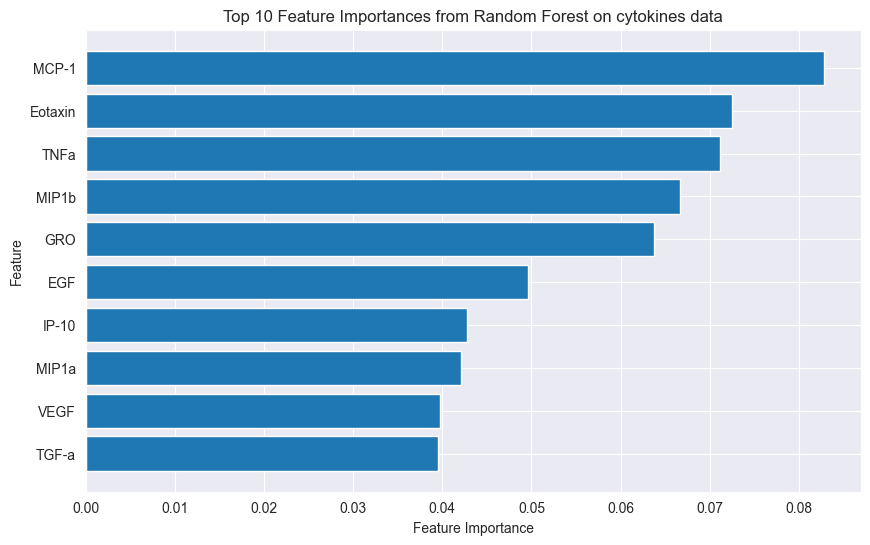

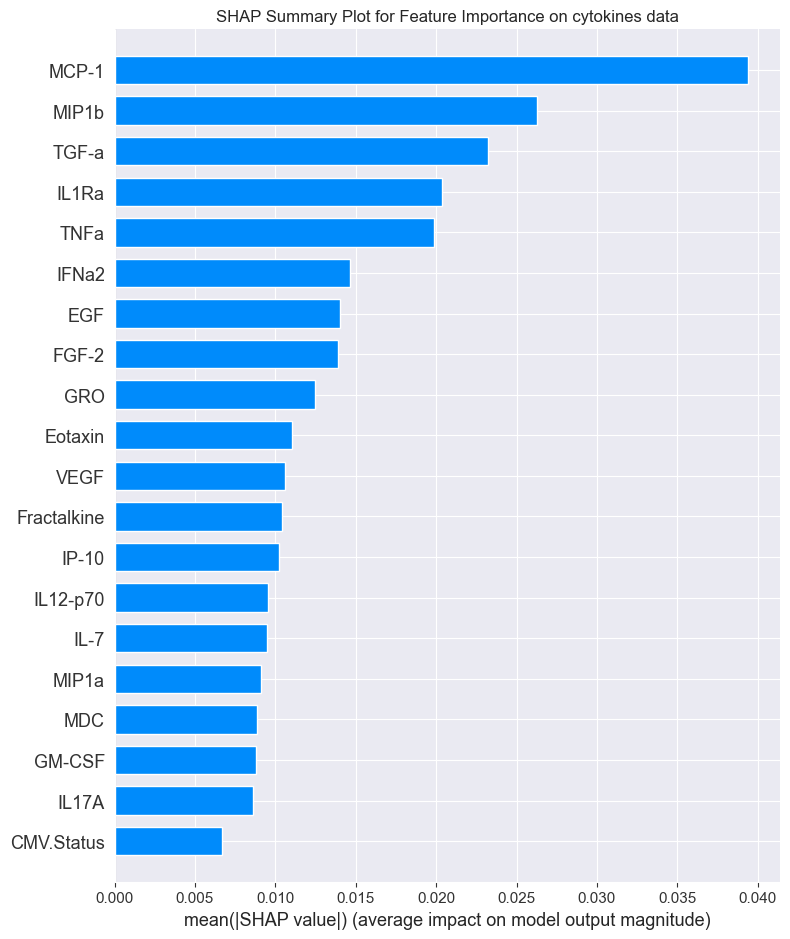

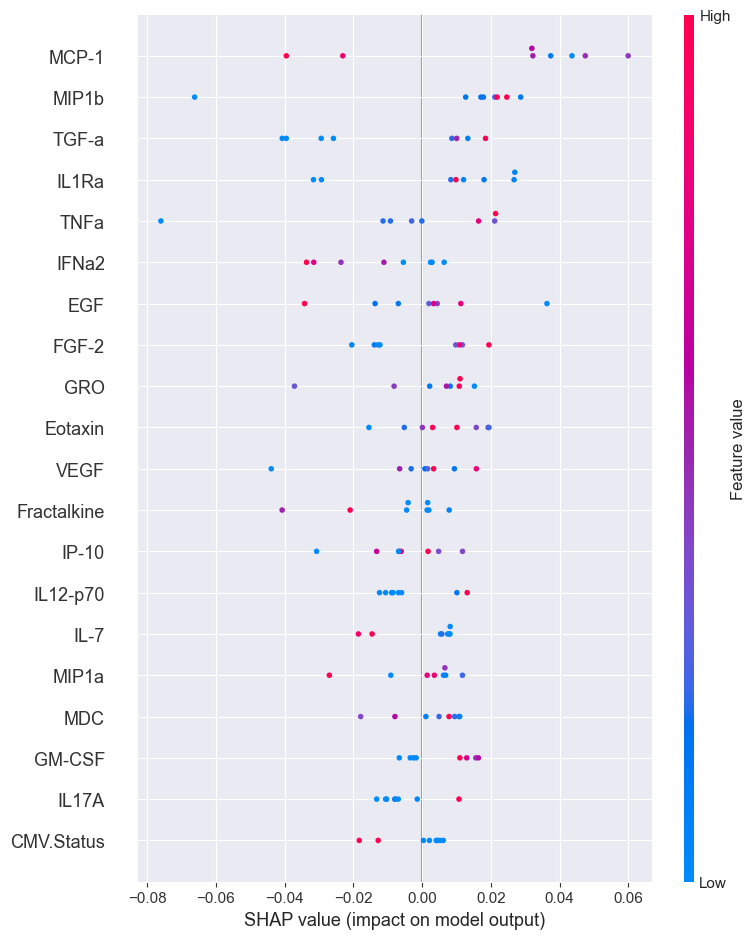

==========cyto==========
Random Forest Model Accuracy: 0.75


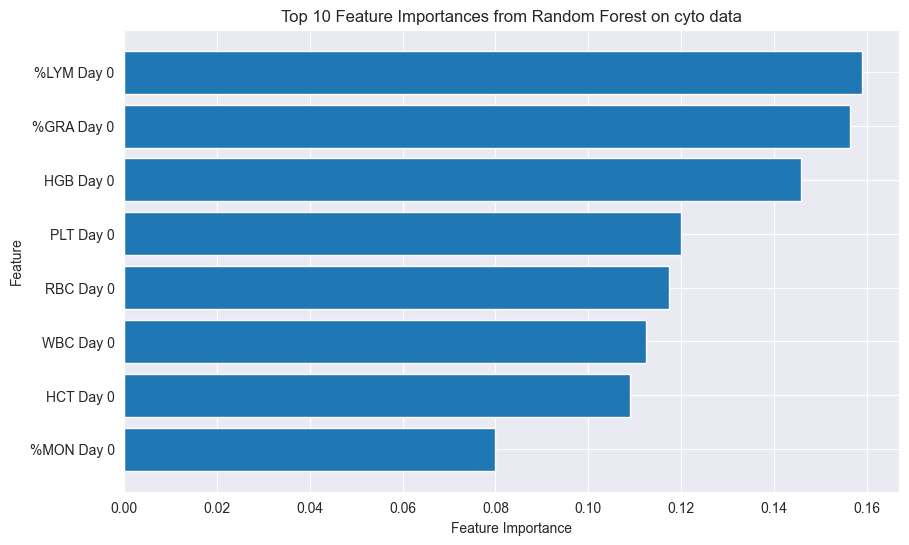

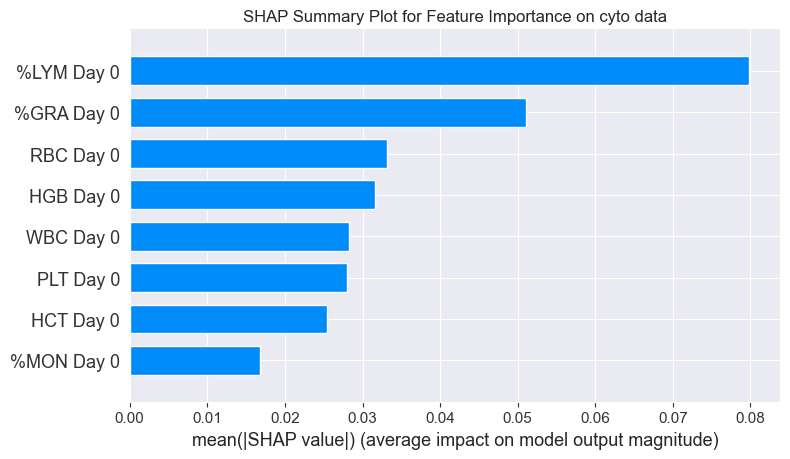

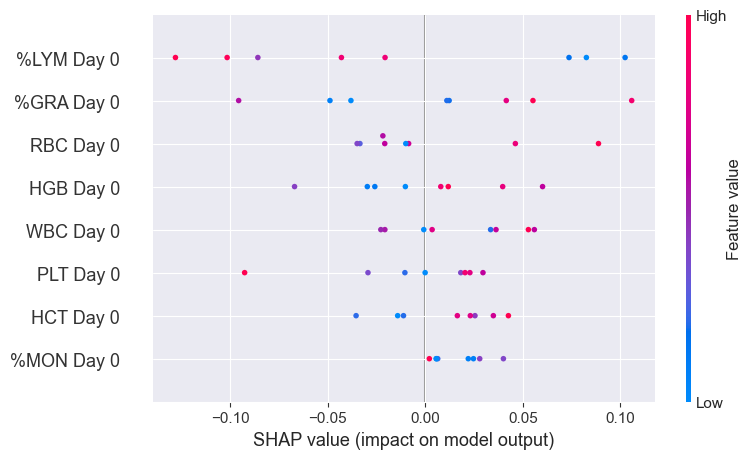

==========metadata==========
Random Forest Model Accuracy: 0.62


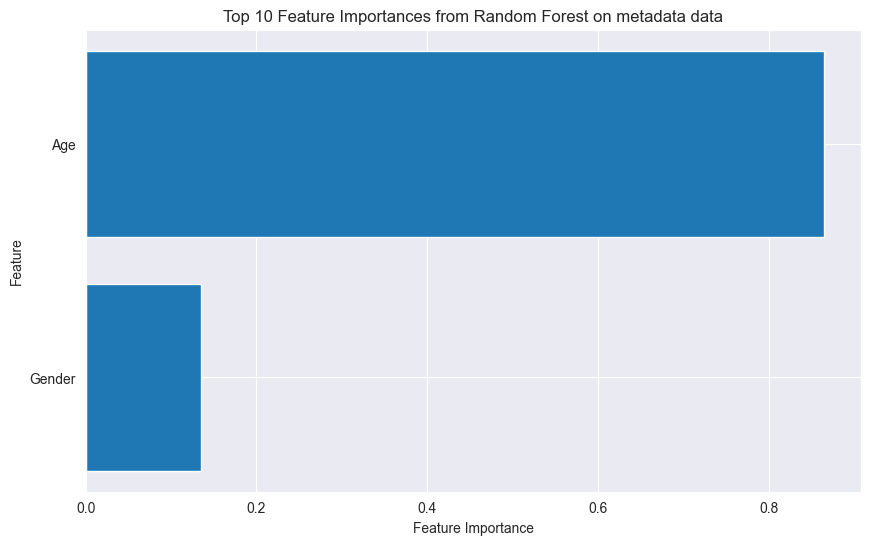

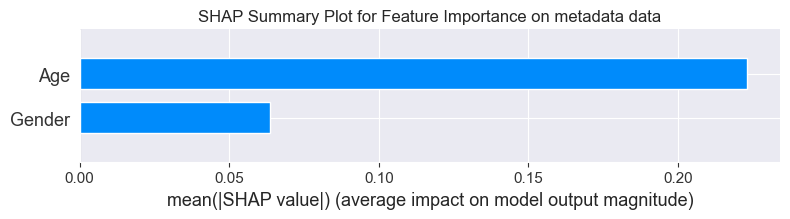

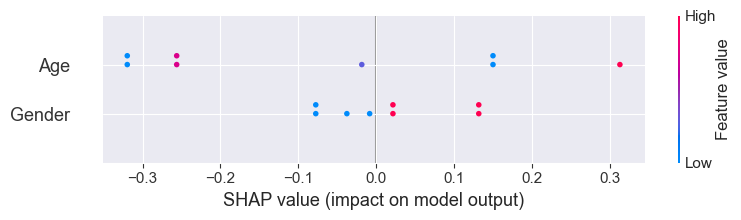

==========cytokines,metadata,cyto==========
Random Forest Model Accuracy: 0.62


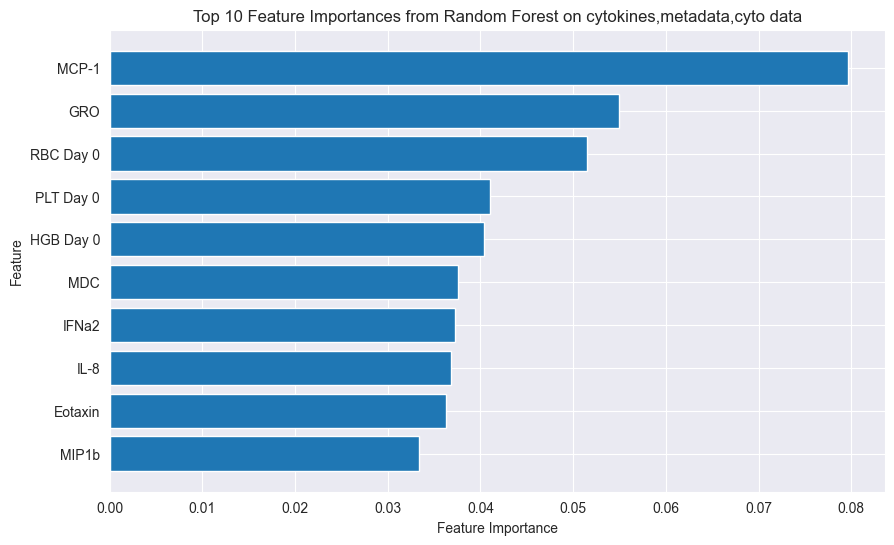

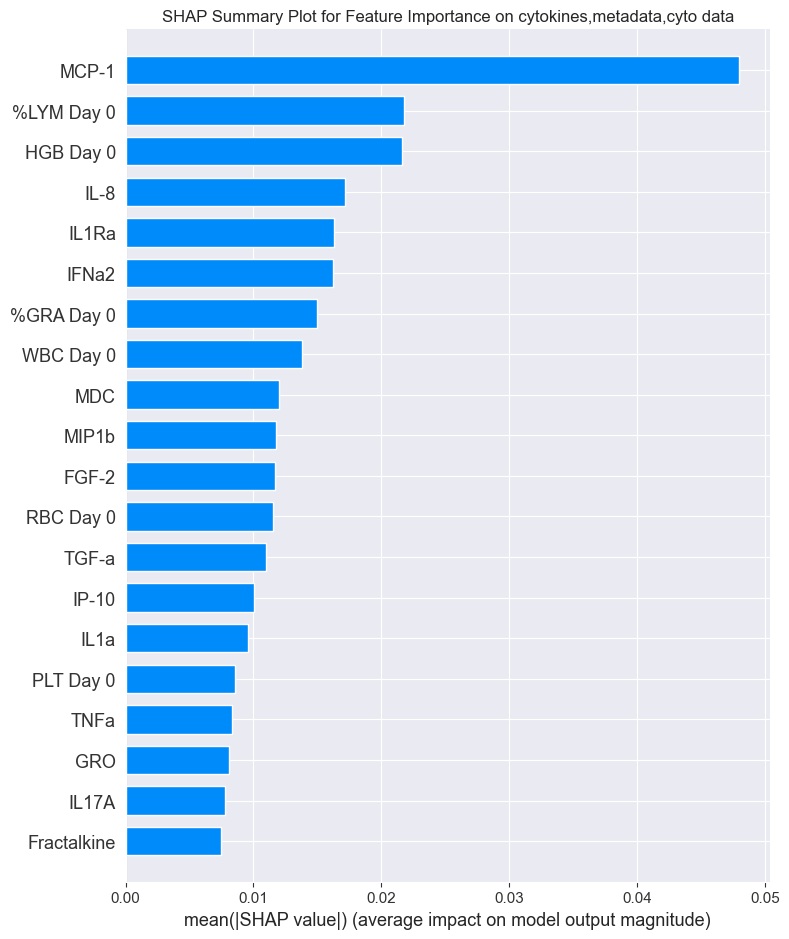

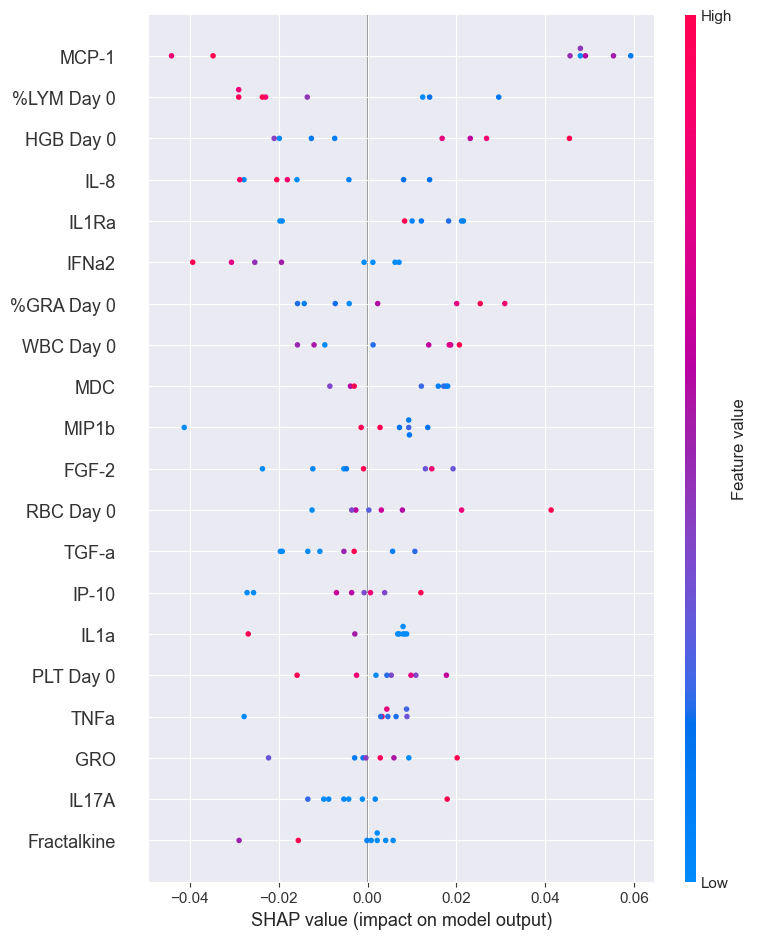

In [13]:
def random_forest_for_baseline_importance(data, title=""):
    # Prepare data for Random Forest (X = features, y = response_label)
    merged_data = pd.merge(abtiters, data, on='Vaccinee')
    X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])
    y = merged_data['response_label']
   
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Calculate accuracy on test data
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Forest Model Accuracy: {accuracy:.2f}")
    
    # Get feature importances from the model
    feature_importances = rf_model.feature_importances_
    
    # Sort features by importance and display top 10
    important_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh([feature for feature, _ in important_features[:10]], 
             [importance for _, importance in important_features[:10]])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Feature Importances from Random Forest on {title} data")
    plt.gca().invert_yaxis()
    plt.show()
    
    # SHAP Analysis
    explainer = shap.TreeExplainer(rf_model, X_train)
    shap_values = np.array(explainer.shap_values(X_test, approximate=True))
    shap_values_ = shap_values.transpose((2, 0, 1)) 
   
    # Summary plot for SHAP values
    plt.title(f"SHAP Summary Plot for Feature Importance on {title} data")
    shap.summary_plot(shap_values_[1], X_test, plot_type="bar")  # Assuming binary classification
    shap.summary_plot(shap_values_[1], X_test)  # Full SHAP summary plot



print(f'{"="*10}cytokines{"="*10}')
random_forest_for_baseline_importance(cytokines, title="cytokines")
print(f'{"="*10}cyto{"="*10}')
random_forest_for_baseline_importance(cyto, title="cyto")
print(f'{"="*10}metadata{"="*10}')
random_forest_for_baseline_importance(metadata, title="metadata")

print(f'{"="*10}cytokines,metadata,cyto{"="*10}')
cytokines_cyto = pd.merge(cytokines, cyto, on='Vaccinee')
all_merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
random_forest_for_baseline_importance(all_merged, title="cytokines,metadata,cyto")


1. Cytokines Data
- Top Random Forest Important Features: MCP-1, Eotaxin, TNFa, MIP1b, and GRO stand out as the most important features. MCP-1 has the highest feature importance score, indicating it is critical in predicting the response.
- SHAP Analysis: The SHAP values show MCP-1 and MIP1b as leading contributors, followed by TGF-a and IL1Ra. This aligns with Random Forest importance, affirming that MCP-1 and MIP1b are highly influential.

2. Cyto Data
- Top Random Forest Important Features: %LYM Day 0 and %GRA Day 0 are the most influential, followed closely by HGB Day 0 and PLT Day 0. These features dominate the importance rankings.
- SHAP Analysis: The SHAP summary aligns with Random Forest results, showing %LYM Day 0 and %GRA Day 0 as impactful. This consistency suggests these features play a major role in predicting response.

3. Metadata
- Top Random Forest Important Features: Age has an overwhelming importance, with Gender contributing minimally.
- SHAP Analysis: Similarly, Age has a dominant influence, indicating that it may correlate strongly with response, whereas Gender has a much smaller impact.

4. Combined Sets (Cyto + Metadata and Cytokines + Metadata)
- Random Forest Feature Importance: MCP-1 remains the most critical feature, suggesting its dominant role across datasets. GRO, RBC Day 0, and PLT Day 0 follow, indicating that features from the cyto data (e.g., RBC, PLT, HGB) are also crucial predictors.
- SHAP Summary Plot: MCP-1 has the highest mean absolute SHAP value, confirming its strong impact on the model’s prediction. %LYM Day 0 and HGB Day 0 from the cyto set also rank highly, suggesting that lymphocyte and hemoglobin percentages are influential predictors for response.

> MCP-1, %LYM Day 0, HGB Day 0, and GRO stand out as highly impactful features across all metrics (importance and SHAP values).

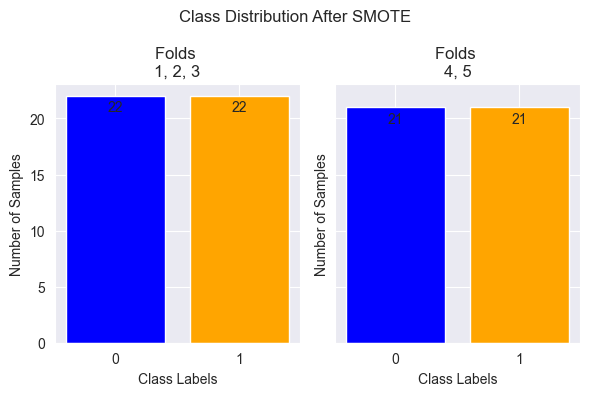

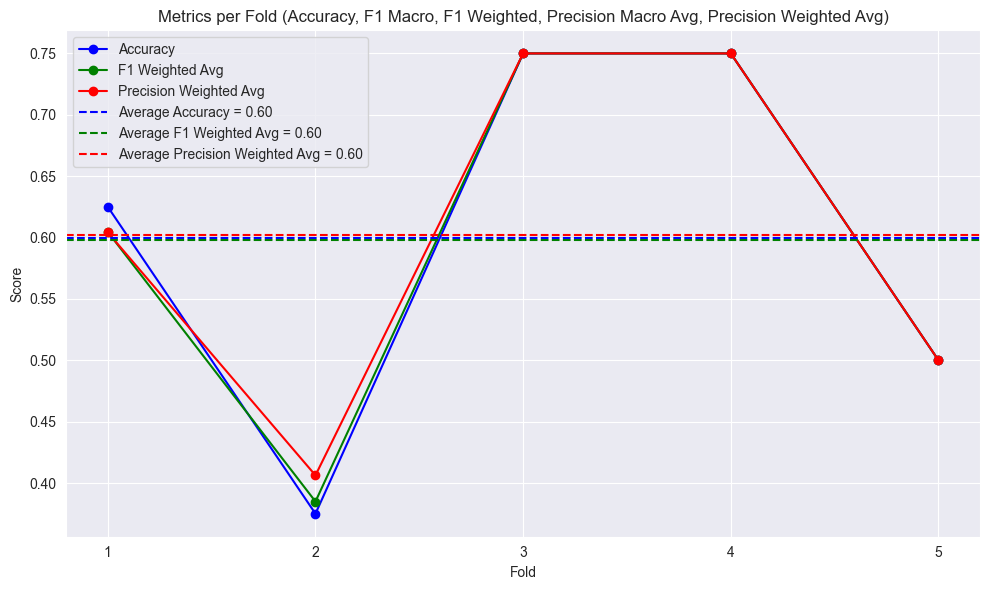

True Negatives (TN): 1.00 -> Correctly predicted negative class.
False Negatives (FN): 1.60 -> Incorrectly predicted negative class.
True Positives (TP): 3.80 -> Correctly predicted positive class.
False Positives (FP): 1.60 -> Incorrectly predicted positive class.


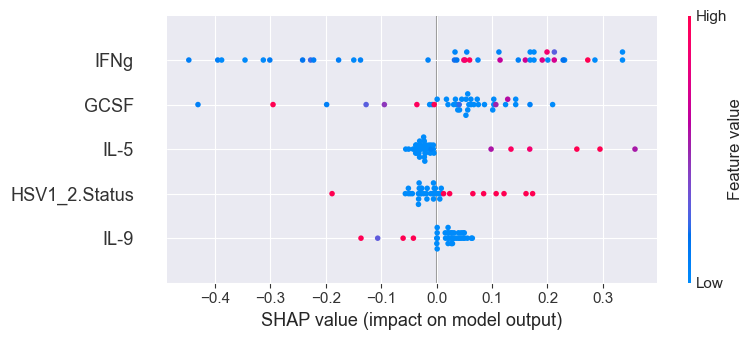

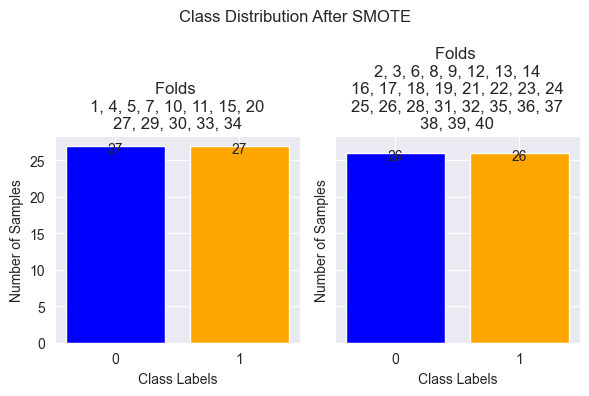

Accuracy: 0.650
f1-macro avg: 0.615
f1-weighted avg: 0.656
precision-macro avg: 0.613
precision-weighted avg: 0.665
True Negatives (TN): 7.00 -> Correctly predicted negative class.
False Negatives (FN): 8.00 -> Incorrectly predicted negative class.
True Positives (TP): 19.00 -> Correctly predicted positive class.
False Positives (FP): 6.00 -> Incorrectly predicted positive class.


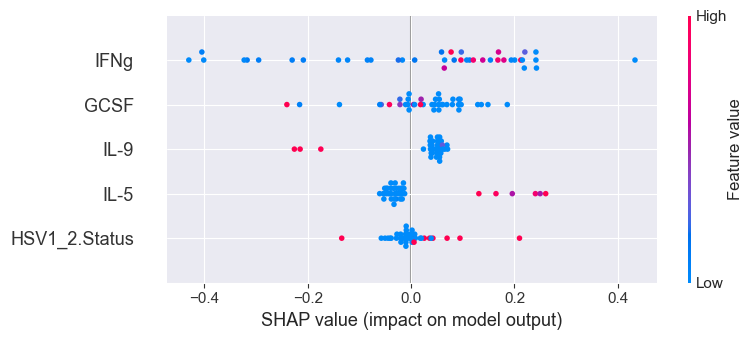

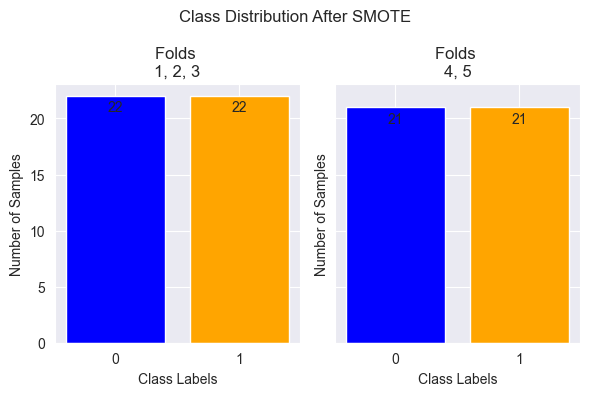

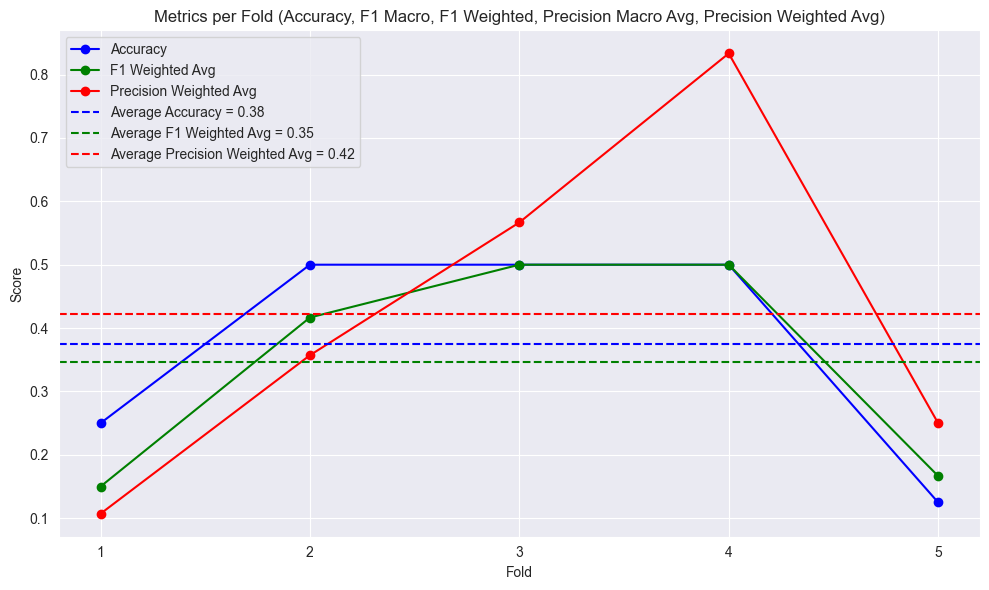

True Negatives (TN): 1.20 -> Correctly predicted negative class.
False Negatives (FN): 3.60 -> Incorrectly predicted negative class.
True Positives (TP): 1.80 -> Correctly predicted positive class.
False Positives (FP): 1.40 -> Incorrectly predicted positive class.


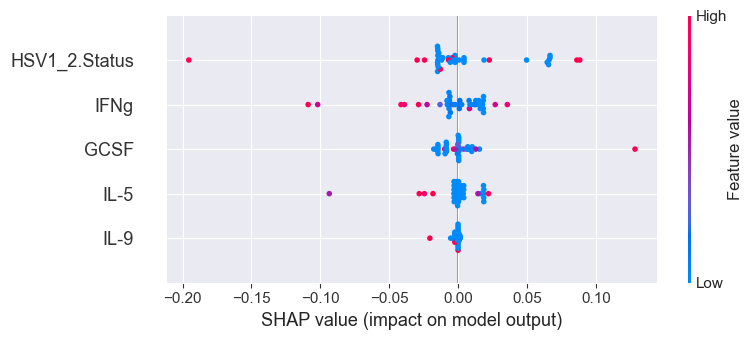

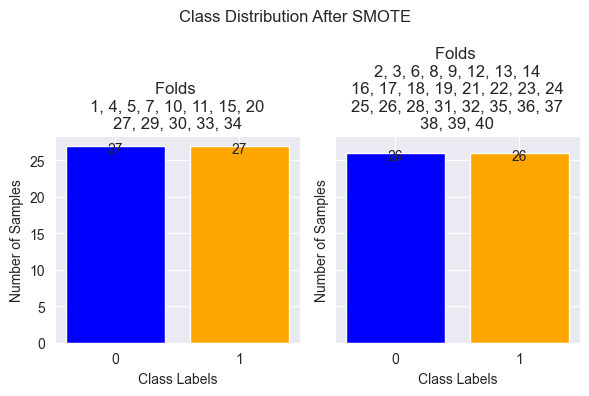

Accuracy: 0.400
f1-macro avg: 0.398
f1-weighted avg: 0.388
precision-macro avg: 0.473
precision-weighted avg: 0.530
True Negatives (TN): 9.00 -> Correctly predicted negative class.
False Negatives (FN): 20.00 -> Incorrectly predicted negative class.
True Positives (TP): 7.00 -> Correctly predicted positive class.
False Positives (FP): 4.00 -> Incorrectly predicted positive class.


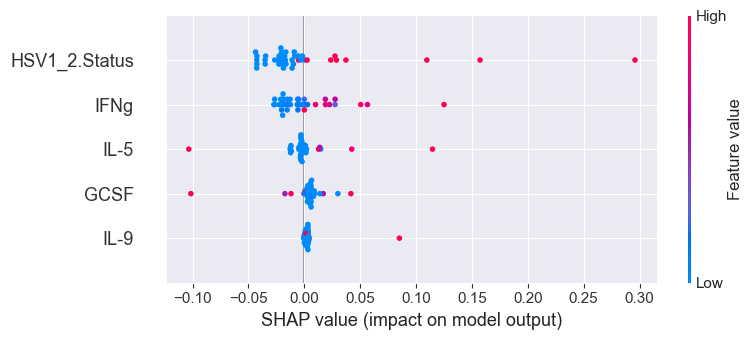

In [59]:
# Drop non-numeric columns
merged_data = pd.merge(abtiters, all_merged, on='Vaccinee')

X = merged_data[['MCP-1', '%LYM Day 0', 'HGB Day 0', 'IL-8', 'IFNa2', 'GRO', 'RBC Day 0', 'HCT Day 0']]
#[['MCP-1', '%LYM Day 0', 'HGB Day 0', 'GRO']] #[['IFNa2', 'GRO', 'MCP-1', 'RBC Day 0', 'HCT Day 0']] is better (trail and error)

# Target variable
y = merged_data['response_label']

model_with_shap(X, y, 
                crossval="K-fold",
                n_splits=5,
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

model_with_shap(X, y, 
                crossval="Leave-One-Out",
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

# Standardize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)  # Convert back to DataFrame for consistency

# Call the function with the SVM model and KernelExplainer for SHAP
model_with_shap(X_normalized, y, 
                crossval="K-fold",
                n_splits=5,
                smote=True, 
                model=SVC(kernel='rbf', probability=True, random_state=42),
                shap_explainer=shap.KernelExplainer)

model_with_shap(X_normalized, y, 
                crossval="Leave-One-Out",
                smote=True, 
                model=SVC(kernel='rbf', probability=True, random_state=42),
                shap_explainer=shap.KernelExplainer)

#### Recursive Feature Elimination

In [28]:
# Define a function to run RFE for different values of n_features and capture the results
def recursive_feature_elimination_all(X, y, max_features=10):
    # Initialize a list to store results for each n_features
    results = []
    
    for n_features in range(1, max_features + 1):
        
        # Initialize the Random Forest Classifier
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Set up RFE with the specified number of features
        rfe = RFE(estimator=rf_model, n_features_to_select=n_features, step=1)
        
        # Fit RFE to select the most important features
        rfe.fit(X, y)
        
        # Get the rankings of features
        selected_features = X.columns[rfe.support_]
        
        # Filter the dataset to include only the selected features
        X_rfe = X[selected_features]
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
        
        # Apply SMOTE to balance the training set
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        # Train the Random Forest model on the balanced dataset
        rf_model.fit(X_train_balanced, y_train_balanced)
        y_pred = rf_model.predict(X_test)
        
        # Calculate accuracy and store results
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append the results to the list
        results.append({
            "n_features": n_features,
            "selected_features": selected_features.tolist(),
            "accuracy": accuracy
        })
        
    # Convert results to a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    return results_df

# Drop non-numeric columns from X
X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['response_label']

# Run RFE across all values of n_features up to the maximum number of features
results_df = recursive_feature_elimination_all(X=X, y=y, max_features=len(X.columns))

# Display the results
results_df


,n_features,selected_features,accuracy
0,1,[GRO],0.625
1,2,"[GRO, MCP-1]",0.625
2,3,"[GRO, MCP-1, RBC Day 0]",0.625
3,4,"[GRO, MCP-1, RBC Day 0, HCT Day 0]",0.625
4,5,"[IFNa2, GRO, MCP-1, RBC Day 0, HCT Day 0]",0.625
5,6,"[IFNa2, GRO, MCP-1, RBC Day 0, HCT Day 0, PLT ...",0.625
6,7,"[IFNa2, GRO, IP-10, MCP-1, RBC Day 0, HCT Day ...",0.500
7,8,"[IFNa2, GRO, IP-10, MCP-1, MIP1b, RBC Day 0, H...",0.625
8,9,"[IFNa2, GRO, IP-10, MCP-1, MIP1b, WBC Day 0, R...",0.625
9,10,"[Fractalkine, IFNa2, GRO, IP-10, MCP-1, MIP1b,...",0.625


#### Recursive Feature Elimination with SMOTE and cross-validation 
This is not really that representable. So next I'm going to look for the optimal subset of features by combining Recursive Feature Elimination (RFE) with SMOTE and testing two different cross-validation approaches.

In [128]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pandas as pd
import numpy as np

# Function for cross-validated RFE
def cross_validated_recursive_feature_elimination(X, y, model, max_features=10, cv=5):
    results = []
    
    # Use tqdm for progress tracking
    for n_features in tqdm(range(1, max_features + 1), desc="RFE Progress", unit="feature set"):
        
        # Define RFE with specified importance_getter
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)

        # Create a pipeline with SMOTE and RFE
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),  # Apply SMOTE within each fold
            ('feature_selection', rfe),
            ('classification', model)
        ])
        
        # Perform Stratified K-Fold Cross-Validation
        cv_ = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=cv_, scoring=make_scorer(accuracy_score))
        
        # Fit the pipeline on the entire dataset to determine selected features
        pipeline.fit(X, y)
        selected_features = X.columns[pipeline.named_steps['feature_selection'].support_].tolist()
        
        # Store results
        mean_score = scores.mean()
        results.append({
            "n_features": n_features,
            "selected_features": selected_features,
            "average_accuracy": mean_score,
        })
    
    return pd.DataFrame(results)

# Function for LOOCV RFE
def loocv_recursive_feature_elimination(X, y, model, max_features=10):
    results = []
    loo = LeaveOneOut()
    
    for n_features in range(1, max_features + 1):
        
        # Define RFE with specified importance_getter
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
        
        # Create a pipeline with SMOTE and RFE
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),  # SMOTE applied to training data only
            ('feature_selection', rfe),
            ('classification', model)
        ])
        
        # Perform Leave-One-Out Cross-Validation
        scores = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)
            
            # Predict on the test sample
            y_pred = pipeline.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        
        # Calculate mean accuracy
        mean_score = np.mean(scores)
        
        # Fit the pipeline on the entire dataset to retrieve selected features
        pipeline.fit(X, y)
        selected_features = X.columns[pipeline.named_steps['feature_selection'].support_].tolist()
        
        # Store results, including selected features
        results.append({
            "n_features": n_features,
            "selected_features": selected_features,
            "average_accuracy": mean_score,
        })
    
    return pd.DataFrame(results)

In [129]:
# Prepare your data
X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])
y = merged_data['response_label']

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [130]:
cv_results_rf = cross_validated_recursive_feature_elimination(X=X, y=y, model=rf_model, max_features=len(X.columns), cv=5)
cv_results_rf

RFE Progress: 100%|██████████| 50/50 [06:11<00:00,  7.43s/feature set]


,n_features,selected_features,average_accuracy
0,1,[GRO],0.700
1,2,"[GRO, RBC Day 0]",0.725
2,3,"[GRO, MCP-1, RBC Day 0]",0.750
3,4,"[GRO, MCP-1, WBC Day 0, RBC Day 0]",0.700
4,5,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0]",0.675
5,6,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0, HCT Da...",0.675
6,7,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.675
7,8,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.650
8,9,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.650
9,10,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.650


In [131]:
lr_results_rf = loocv_recursive_feature_elimination(X=X, y=y, model=rf_model, max_features=len(X.columns))
lr_results_rf

,n_features,selected_features,average_accuracy
0,1,[GRO],0.725
1,2,"[GRO, RBC Day 0]",0.650
2,3,"[GRO, MCP-1, RBC Day 0]",0.625
3,4,"[GRO, MCP-1, WBC Day 0, RBC Day 0]",0.575
4,5,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0]",0.550
5,6,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0, HCT Da...",0.500
6,7,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.500
7,8,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.550
8,9,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.600
9,10,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.575


In [132]:
# Define the SVC model (does not work)
# svc_model = SVC(kernel='rbf', probability=True, random_state=42)
# cv_results_svc = cross_validated_recursive_feature_elimination(X=X, y=y, model=svc_model, max_features=len(X.columns), cv=5)
# cv_results_svc
# lr_results_svc = loocv_recursive_feature_elimination(X=X, y=y, model=svc_model, max_features=len(X.columns))
# lr_results_svc

I'm gonna group correlated features

In [15]:
# Define the groups of correlated features
group_1 = ['IL1Ra', 'TNFb', 'MCP3', 'IL-13']
group_2 = ['IL-9', 'IL-10', 'GM-CSF', 'IL-2'] # ,'IL-7', 'IFNa2'
group_3 = ['IL12-p70', 'IFNg', 'IL17A', 'TGF-a', 'TNFa'] # ,'MIP1b', 'FGF-2', 'VEGF', 'Flt3 Ligand'
group_4 = ['Fractalkine', 'IL-15'] # ,'IL-1b' 

# Perform PCA on each group and create a new feature based on the first principal component
def compress_features(data, features, new_feature_name):
    pca = PCA(n_components=1)  # We only need the first principal component
    principal_component = pca.fit_transform(data[features])
    data[new_feature_name] = principal_component
    return data

# Compress the groups and create new features
merged_data = compress_features(merged_data, group_1, 'Group_1_Compressed')
merged_data = compress_features(merged_data, group_2, 'Group_2_Compressed')
merged_data = compress_features(merged_data, group_3, 'Group_3_Compressed')
merged_data = compress_features(merged_data, group_4, 'Group_4_Compressed')

# Drop the original features that are now compressed
merged_data.drop(columns=group_1 + group_2 + group_3 + group_4, inplace=True)

Run everything again with the clusters

In [134]:
# Prepare your data
X = merged_data.drop(columns=['Day 0', 'Day 21', 'titer_response', 'Vaccinee', 'response_label', 'vaccine'])
y = merged_data['response_label']

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [135]:
cv_results_rf = cross_validated_recursive_feature_elimination(X=X, y=y, model=rf_model, max_features=len(X.columns), cv=5)
cv_results_rf

RFE Progress: 100%|██████████| 39/39 [05:14<00:00,  8.05s/feature set]


,n_features,selected_features,average_accuracy
0,1,[GRO],0.700
1,2,"[GRO, RBC Day 0]",0.725
2,3,"[GRO, MCP-1, RBC Day 0]",0.750
3,4,"[GRO, MCP-1, WBC Day 0, RBC Day 0]",0.625
4,5,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0]",0.625
5,6,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0, HCT Da...",0.675
6,7,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.650
7,8,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.675
8,9,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.675
9,10,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.625


In [136]:
lr_results_rf = loocv_recursive_feature_elimination(X=X, y=y, model=rf_model, max_features=len(X.columns))
lr_results_rf

,n_features,selected_features,average_accuracy
0,1,[GRO],0.725
1,2,"[GRO, RBC Day 0]",0.650
2,3,"[GRO, MCP-1, RBC Day 0]",0.625
3,4,"[GRO, MCP-1, WBC Day 0, RBC Day 0]",0.600
4,5,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0]",0.575
5,6,"[GRO, MDC, MCP-1, WBC Day 0, RBC Day 0, HCT Da...",0.550
6,7,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.550
7,8,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.575
8,9,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.625
9,10,"[GRO, MDC, IP-10, MCP-1, WBC Day 0, RBC Day 0,...",0.575


In [137]:
# Define the SVC model  (does not work)
# svc_model = SVC(kernel='rbf', probability=True, random_state=42)

# cv_results_svc = cross_validated_recursive_feature_elimination(X=X, y=y, model=svc_model, max_features=len(X.columns), cv=5)
# cv_results_svc
# lr_results_svc = loocv_recursive_feature_elimination(X=X, y=y, model=svc_model, max_features=len(X.columns))
# lr_results_svc